# XGBoost

In [206]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from utils.model import save_model
from sklearn.model_selection import learning_curve

# Feature Engineering Imports
from utils.utils import apply_one_hot_encoding, full_categorical_columns, align_features

# Preprocessing Imports
from utils.utils import numerical_columns, remove_outliers, apply_scaling, total_columns_to_check

# Evaluation Imports
from utils.utils import evaluate_model

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
# Load the cleaned data
train_data = pd.read_csv("data/cleaned_Train.csv")

# Remove outliers
train_data = remove_outliers(train_data, columns=total_columns_to_check, method='iqr')

# Define target and categorical columns
target_column = 'total_cost'
categorical_columns = full_categorical_columns  # Your predefined list of categorical columns

In [208]:
# Label Encoding for Categorical Features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le  # Store encoders for potential future use

In [209]:
# Split Features and Target
X = train_data.drop(columns=[target_column])  # All features except the target
y = np.log1p(train_data[target_column])  # Log-transform target to handle skewness

In [210]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
# Train the XGBoost Model with Categorical Support
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,  # Enable handling of categorical features
    random_state=42,
    n_estimators=100,          # Start with 100 trees
    max_depth=6,               # Depth of trees
    learning_rate=0.1          # Learning rate
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [212]:
# Predictions
y_val_pred = xgb_model.predict(X_val)

# Transform predictions back to the original scale
y_val_pred_actual = np.expm1(y_val_pred)
y_val_actual = np.expm1(y_val)

# Evaluate the model
metrics = evaluate_model(y_val, y_val_pred)

Validation Set Metrics:
Mean Absolute Error (MAE): 0.786570275186922
Mean Squared Error (MSE): 1.1014060477841598
Root Mean Squared Error (RMSE): 1.0494789410865564
R² Score: 0.5412359814411238


In [213]:
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
# Print results
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Cross-Validation R² Scores: [0.5166498  0.50430342 0.50114521 0.48471808 0.50130216]
Mean R² Score: 0.5016237320247086
Standard Deviation of R² Score: 0.010189177755107325


In [214]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top Features:")
print(feature_importance.head(23))

Top Features:
                  Feature  Importance
8        tour_arrangement    0.570007
10   package_accomodation    0.243225
23           total_nights    0.028974
22           total_people    0.024915
12   package_transport_tz    0.017085
5                 purpose    0.012450
11           package_food    0.011554
9   package_transport_int    0.008060
18           payment_mode    0.007453
0                 country    0.006987
15      package_insurance    0.006477
17         night_zanzibar    0.006392
6           main_activity    0.005915
16         night_mainland    0.005885
7             info_source    0.005817
2             travel_with    0.005453
1               age_group    0.005195
20        most_impressing    0.005174
14    package_guided_tour    0.005014
13    package_sightseeing    0.004980
19          first_trip_tz    0.004943
3            total_female    0.004863
4              total_male    0.003184


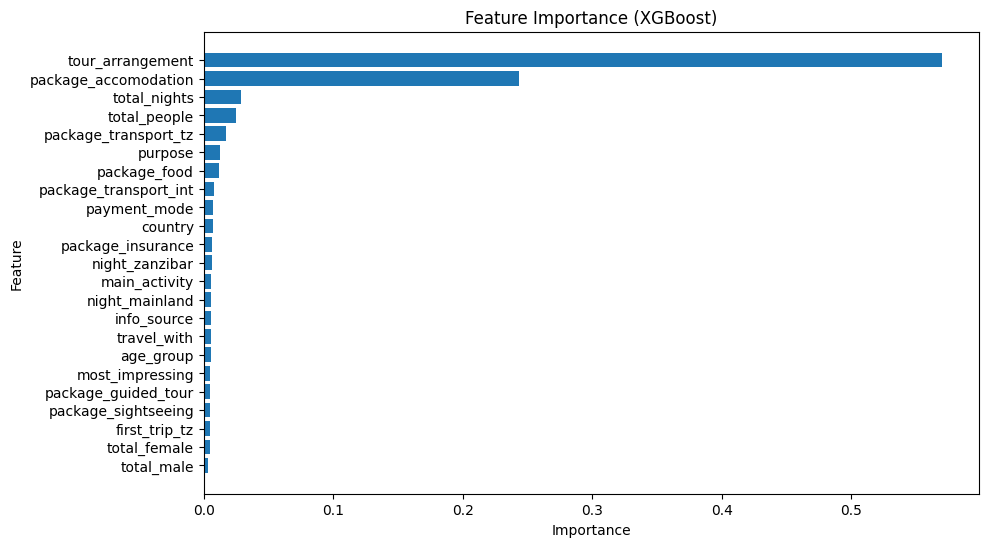

In [215]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:23], feature_importance['Importance'][:23])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

In [216]:
# Define the hyperparameter grid for random search
param_dist = {
    'n_estimators': [50, 100, 200, 500],          # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Shrinkage factor for updates
    'max_depth': [3, 5, 7, 10],                   # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],                 # Fraction of samples for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],          # Fraction of features per tree
    'min_child_weight': [1, 3, 5, 10]             # Minimum sum of instance weights in a child
}

In [217]:
# Select important features (already computed previously)
important_features = feature_importance[feature_importance['Importance'] > 0.005]['Feature']
X_train_important = X_train[important_features]
X_val_important = X_val[important_features]

# Initialize the XGBoost model
xgb_random_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_random_model,
    param_distributions=param_dist,
    n_iter=50,                # Number of random combinations to try
    cv=5,                     # 5-fold cross-validation
    scoring='r2',             # Optimize for R² Score
    n_jobs=-1,                # Use all available cores
    verbose=2,                # Show progress
    random_state=42           # Ensure reproducibility
)

# Perform random search on the important features
random_search.fit(X_train_important, y_train)

# Get the best model and parameters
best_xgb_random_model = random_search.best_estimator_
best_params_random = random_search.best_params_
print("Best Parameters:", best_params_random)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [218]:
# Validate the tuned model on the validation set
y_val_random_pred = best_xgb_random_model.predict(X_val_important)

# Evaluate the model's performance
metrics_random = evaluate_model(y_val, y_val_random_pred)


Validation Set Metrics:
Mean Absolute Error (MAE): 0.7620678607417285
Mean Squared Error (MSE): 1.0498645342714072
Root Mean Squared Error (RMSE): 1.0246289739566254
R² Score: 0.5627043508125174


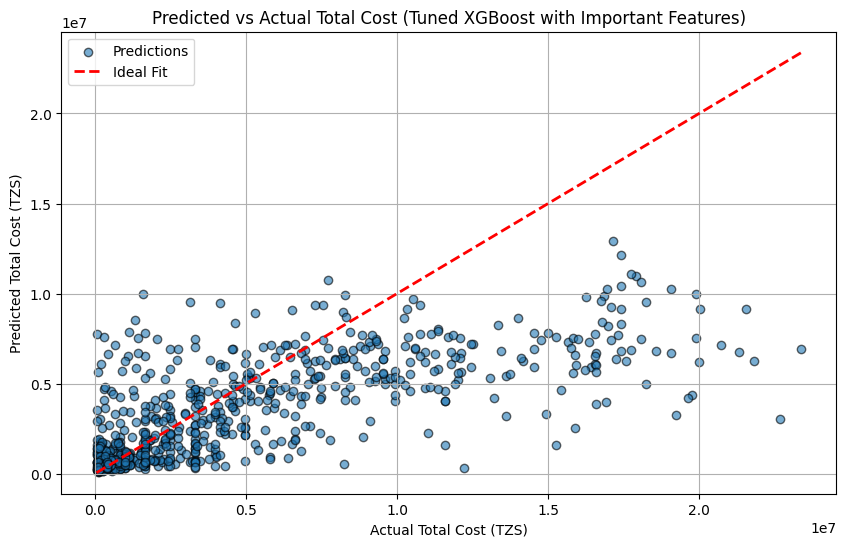

In [232]:
# Convert log-transformed predictions and actual values back to original scale
y_val_original = np.expm1(y_val)  # Reverse log transformation
y_val_pred_original = np.expm1(y_val_random_pred)

# Plot predicted vs actual on the original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, y_val_pred_original, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot(
    [y_val_original.min(), y_val_original.max()], 
    [y_val_original.min(), y_val_original.max()], 
    'r--', lw=2, label="Ideal Fit"
)
plt.title("Predicted vs Actual Total Cost (Tuned XGBoost with Important Features)")
plt.xlabel("Actual Total Cost (TZS)")
plt.ylabel("Predicted Total Cost (TZS)")
plt.legend()
plt.grid(True)
plt.show()

In [220]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Feature'] = X_train_important.columns
vif['VIF'] = [variance_inflation_factor(X_train_important.values, i) for i in range(X_train_important.shape[1])]

print(vif.sort_values(by="VIF", ascending=False))


/Users/manjarb/Sites/bootcamp/data_ai/20-data-bootcamp-ds-ml-project/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                  Feature        VIF
11         night_zanzibar        inf
2            total_nights        inf
13         night_mainland        inf
1    package_accomodation  33.855772
0        tour_arrangement  28.713146
6            package_food  14.432243
3            total_people   8.438130
4    package_transport_tz   6.676803
16              age_group   4.067515
15            travel_with   3.919749
18    package_guided_tour   3.825328
9                 country   3.793180
12          main_activity   3.728993
7   package_transport_int   2.969045
14            info_source   2.590196
17        most_impressing   2.372344
5                 purpose   2.043539
10      package_insurance   1.665545
8            payment_mode   1.174621


In [221]:
# Define the parameter grid with regularization
regular_param_grid = {
    'n_estimators': [50, 100, 200],             # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],        # Learning rate
    'max_depth': [3, 5, 7],                    # Maximum depth of trees
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features per tree
    'reg_lambda': [0.1, 1, 10],                # L2 Regularization
    'reg_alpha': [0.01, 0.1, 1],               # L1 Regularization
    'gamma': [0, 1, 5]                         # Minimum loss reduction for split
}

In [222]:
# Initialize the base XGBoost model
xgb_regular_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
random_regular_search = RandomizedSearchCV(
    estimator=xgb_regular_model,
    param_distributions=regular_param_grid,
    n_iter=50,               # Limits iterations for speed
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Train using the search
random_regular_search.fit(X_train_important, y_train)

# Get the best model and parameters
best_xgb_regular_model = random_regular_search.best_estimator_
print("Best Parameters:", random_regular_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}


In [223]:
# Evaluate the tuned model on the validation set
y_val_random_regular_pred = best_xgb_regular_model.predict(X_val_important)

# Evaluate the model's performance
metrics_random_regular = evaluate_model(y_val, y_val_random_regular_pred)

Validation Set Metrics:
Mean Absolute Error (MAE): 0.7629406214431689
Mean Squared Error (MSE): 1.0400406441008487
Root Mean Squared Error (RMSE): 1.0198238299338023
R² Score: 0.5667962543766873


In [224]:
cv_results = random_regular_search.cv_results_
print("Mean CV R² Score:", random_regular_search.best_score_)


Mean CV R² Score: 0.5242342640896621


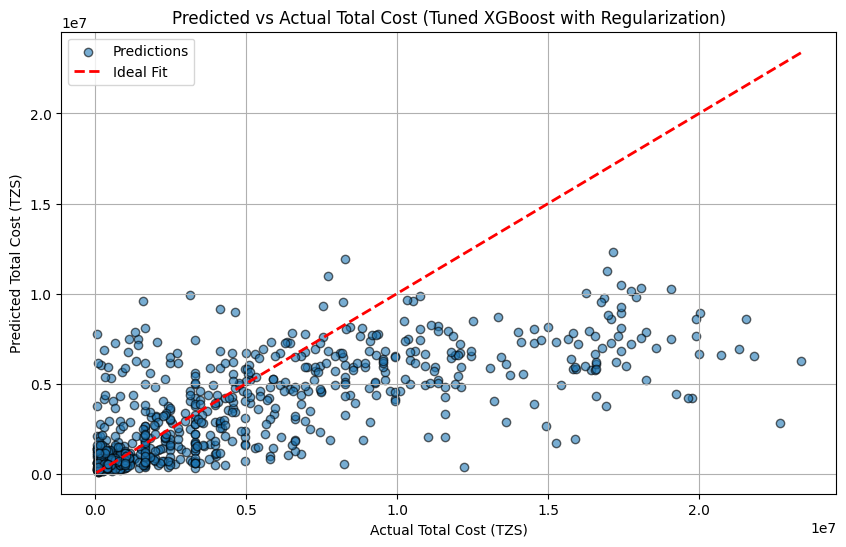

In [233]:
# Convert log-transformed predictions and actual values back to original scale
y_val_original = np.expm1(y_val)  # Reverse log transformation
y_val_pred_original = np.expm1(y_val_random_regular_pred)  # Predicted values back to original scale

# Plot predicted vs actual on the original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, y_val_pred_original, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot(
    [y_val_original.min(), y_val_original.max()], 
    [y_val_original.min(), y_val_original.max()], 
    'r--', lw=2, label="Ideal Fit"
)
plt.title("Predicted vs Actual Total Cost (Tuned XGBoost with Regularization)")
plt.xlabel("Actual Total Cost (TZS)")
plt.ylabel("Predicted Total Cost (TZS)")
plt.legend()
plt.grid(True)
plt.show()


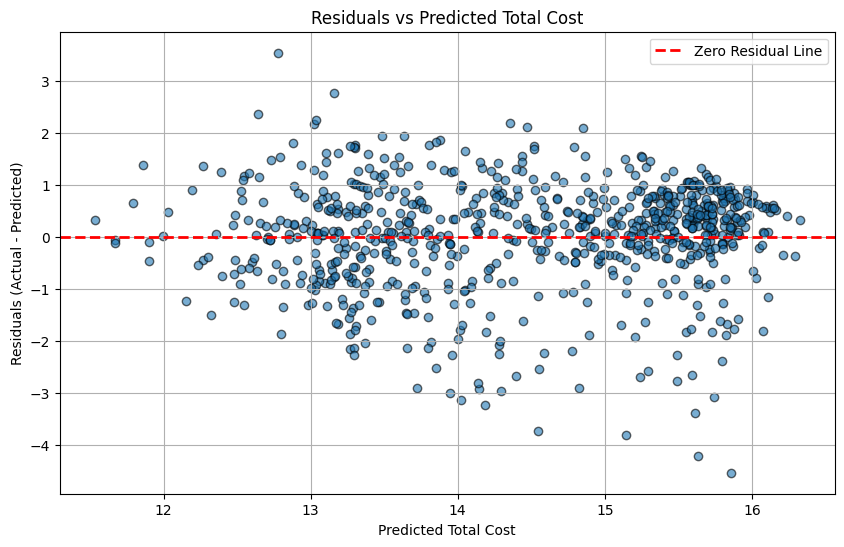

In [225]:
# Calculate residuals
residuals = y_val - y_val_random_regular_pred

# Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val_random_regular_pred, residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residuals vs Predicted Total Cost")
plt.xlabel("Predicted Total Cost")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()


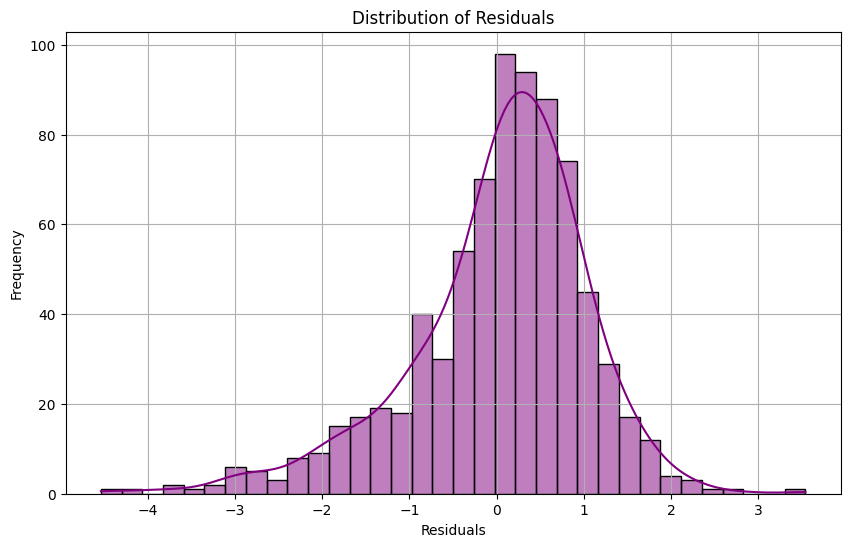

In [226]:
# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


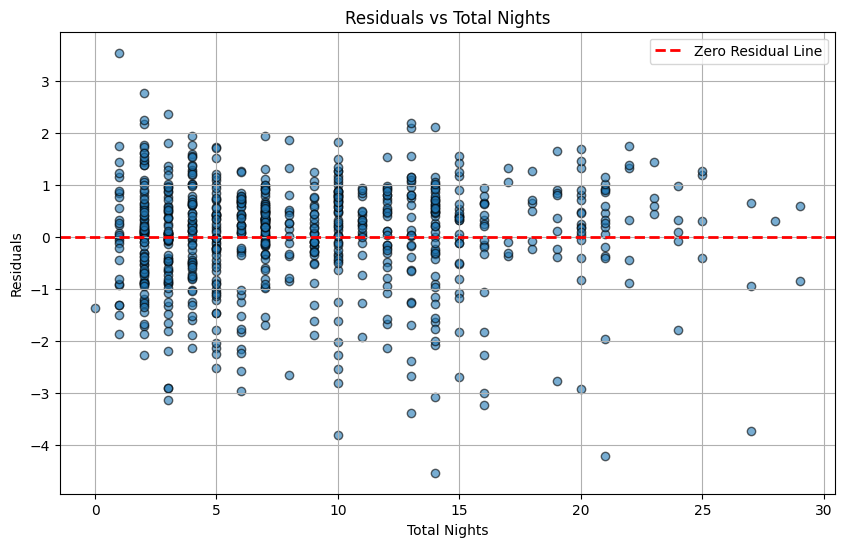

In [227]:
# Residuals vs Important Feature (Example: total_nights)
plt.figure(figsize=(10, 6))
plt.scatter(X_val_important['total_nights'], residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residuals vs Total Nights")
plt.xlabel("Total Nights")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()


In [228]:
# Identify and Display Outliers
residuals_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_random_regular_pred, 'Residuals': residuals})
outliers = residuals_df[np.abs(residuals) > (3 * residuals.std())]

print("Potential Outliers:")
print(outliers)


Potential Outliers:
         Actual  Predicted  Residuals
2938  12.218994  15.610348  -3.391354
1990  11.325101  15.144012  -3.818912
608   10.819798  14.546771  -3.726973
2486  11.413448  15.630633  -4.217186
2092  11.325101  15.861076  -4.535976
1867  10.878820  14.023721  -3.144900
1096  10.949086  14.184673  -3.235588
490   12.653962  15.740954  -3.086993
575   16.317192  12.775610   3.541582


In [229]:
# Save best XGBoost model then
# Assume 'model' is your trained model
save_model(best_xgb_regular_model, 'models/best_XGBoost_model.pkl')

Model saved successfully to: models/best_XGBoost_model.pkl


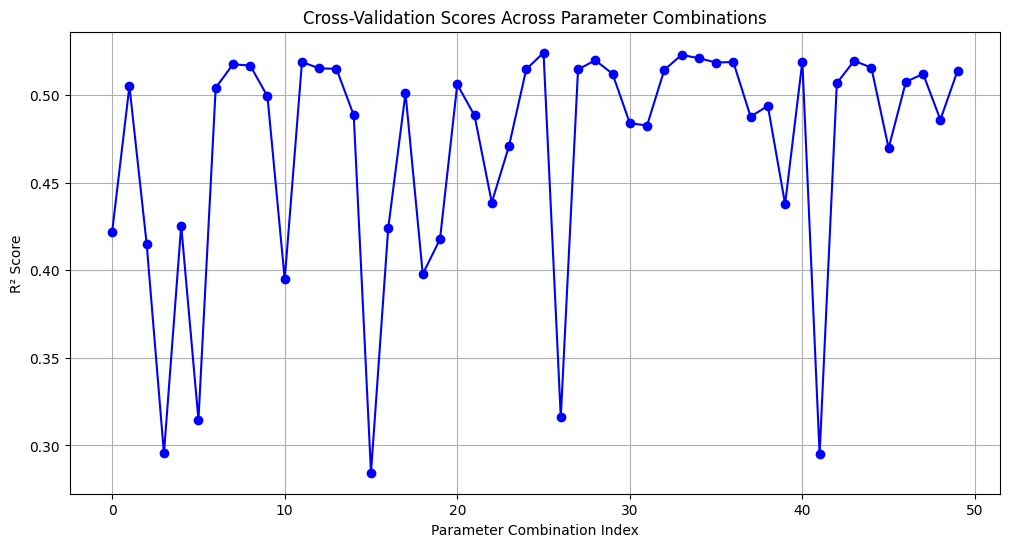

In [230]:
cv_scores = random_regular_search.cv_results_['mean_test_score']
cv_params = random_regular_search.cv_results_['params']

plt.figure(figsize=(12, 6))
plt.plot(range(len(cv_scores)), cv_scores, marker='o', linestyle='-', color='b')
plt.title("Cross-Validation Scores Across Parameter Combinations")
plt.xlabel("Parameter Combination Index")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()

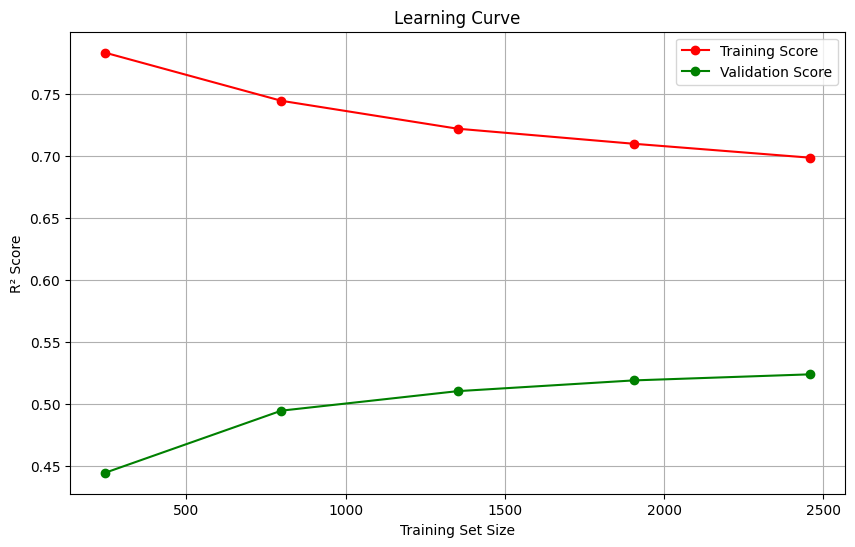

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_

In [231]:
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_regular_model, X_train_important, y_train, cv=5, scoring='r2', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()
